In [1]:
import matplotlib.pyplot as plt

import h5py
import numpy as np
import pandas as pd
import torch

from collections import Counter

from torch.utils.data import ConcatDataset, DataLoader
from torch_geometric.data import DataListLoader

/g/g92/noh1/.local/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from IPython.display import clear_output
from IPython.core.display import HTML
HTML("<style>.container { width:98% !important; }</style>")

In [3]:
os.chdir("..")
print("Current working directory:", os.getcwd())

Current working directory: /g/g92/noh1/fast2


In [4]:
data_dir = "./data/mpro"
file_name = "gmd_postera_protease_pos.h5"
file_path = os.path.join(data_dir, file_name)
print(os.path.exists(file_path))

True


In [5]:
f = h5py.File(file_path, 'r')

In [6]:
data_names = list(f)

In [7]:
len(data_names)

15010

In [8]:
data_names[:15]

['AAR-POS-0daf6b7e-23_protease_1',
 'AAR-POS-0daf6b7e-23_protease_10',
 'AAR-POS-0daf6b7e-23_protease_2',
 'AAR-POS-0daf6b7e-23_protease_3',
 'AAR-POS-0daf6b7e-23_protease_4',
 'AAR-POS-0daf6b7e-23_protease_5',
 'AAR-POS-0daf6b7e-23_protease_6',
 'AAR-POS-0daf6b7e-23_protease_7',
 'AAR-POS-0daf6b7e-23_protease_8',
 'AAR-POS-0daf6b7e-23_protease_9',
 'AAR-POS-5507155c-1_protease_1',
 'AAR-POS-5507155c-1_protease_10',
 'AAR-POS-5507155c-1_protease_2',
 'AAR-POS-5507155c-1_protease_3',
 'AAR-POS-5507155c-1_protease_4']

In [9]:
idx = 1
name = data_names[idx]
# print(f[name]["spatial"].attrs["affinity"])

In [10]:
f.attrs.keys()

<KeysViewHDF5 []>

In [11]:
# attr_names = list(f.attrs.keys())
# for attr_name in attr_names:
#     attr_value = f.attrs[attr_name]
#     print(f"Attribute '{attr_name}': {attr_value}")

for k in f[name].keys():
    print(k)
    for info in f[name][k]:
        print("  ", f[name][k][info])

spatial
   <HDF5 dataset "coords": shape (442, 3), type "<f4">
   <HDF5 dataset "dists": shape (442, 442), type "<f4">
   <HDF5 dataset "node_feats": shape (442, 20), type "<f4">
voxelized
   <HDF5 dataset "data0": shape (19, 48, 48, 48), type "<f4">


In [12]:
f[name]["spatial"]["coords"][:]

array([[ 0.11213303,  0.02486706,  1.3006668 ],
       [ 0.29113293, -0.44513226,  2.4366684 ],
       [-0.5678663 , -0.5981331 ,  0.23966217],
       ...,
       [ 1.8601332 , -3.086133  ,  6.420662  ],
       [ 1.862133  , -2.5641327 ,  5.305664  ],
       [ 2.9411335 , -3.6461325 ,  6.952667  ]], dtype=float32)

In [13]:
f[name]["spatial"]["node_feats"][:]

array([[1.7 , 0.  , 1.  , ..., 0.  , 0.  , 0.  ],
       [1.52, 0.  , 0.  , ..., 1.  , 0.  , 0.  ],
       [1.55, 0.  , 0.  , ..., 1.  , 1.  , 0.  ],
       ...,
       [1.7 , 0.  , 1.  , ..., 0.  , 0.  , 0.  ],
       [1.52, 0.  , 0.  , ..., 1.  , 0.  , 0.  ],
       [1.55, 0.  , 0.  , ..., 1.  , 1.  , 0.  ]], dtype=float32)

In [14]:
f[name]["spatial"]["dists"][:]

array([[0.       , 1.2423526, 1.4057949, ..., 6.2408476, 5.0799036,
        7.3092127],
       [1.2423526, 0.       , 2.3639216, ..., 5.0307903, 3.8973503,
        6.137031 ],
       [1.4057949, 2.3639216, 0.       , ..., 7.0915504, 5.9526825,
        8.165036 ],
       ...,
       [6.2408476, 5.0307903, 7.0915504, ..., 0.       , 1.2311412,
        1.3286048],
       [5.0799036, 3.8973503, 5.9526825, ..., 1.2311412, 0.       ,
        2.2466831],
       [7.3092127, 6.137031 , 8.165036 , ..., 1.3286048, 2.2466831,
        0.       ]], dtype=float32)

In [15]:
x = np.concatenate((f[name]["spatial"]["coords"][:], f[name]["spatial"]["node_feats"][:]), axis=-1)
x.shape

(442, 23)

In [16]:
x

array([[ 0.11213303,  0.02486706,  1.3006668 , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.29113293, -0.44513226,  2.4366684 , ...,  1.        ,
         0.        ,  0.        ],
       [-0.5678663 , -0.5981331 ,  0.23966217, ...,  1.        ,
         1.        ,  0.        ],
       ...,
       [ 1.8601332 , -3.086133  ,  6.420662  , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.862133  , -2.5641327 ,  5.305664  , ...,  1.        ,
         0.        ,  0.        ],
       [ 2.9411335 , -3.6461325 ,  6.952667  , ...,  1.        ,
         1.        ,  0.        ]], dtype=float32)

In [17]:
def get_compound_id(docking_id):
    return docking_id.rsplit("_", 2)[0]

compound_ids = set([get_compound_id(docking_id) for docking_id in data_names])
print(list(compound_ids)[:10])
len(compound_ids)

['MAT-POS-edabd372-2', 'EDJ-MED-e4b030d8-2', 'ALP-POS-902f21bb-1', 'MAT-POS-e9e99895-8', 'LON-WEI-b2874fec-19', 'LOR-NEU-c8f11034-2', 'EDJ-MED-cf4b0d25-3', 'STU-CHA-6cae54d3-1', 'LON-WEI-4d77710c-49', 'MAT-POS-9ff17035-3']


1501

In [18]:
compound_info = pd.read_csv(os.path.join(data_dir, "updated_mpro_positive_compounds.csv"))
compound_info = compound_info[compound_info.activity_type == "pIC50"]
compound_info

,compound_id,SMILES,relation,activity,activity_type
0,GoStar-gvk_125547054,CC(C)(C)NC(=O)N[C@H](C(=O)N1C[C@H]2[C@@H]([C@H...,NaN,5.681024,pIC50
1,PostEra-EDJ-MED-cf4b0d25-4,CC(=O)NC(C(=O)Nc1cncc2ccccc12)c1cccc(Cl)c1,NaN,5.039634,pIC50
2,PostEra-EDJ-MED-976a33d5-1,CNC(=O)C1(N2CC3(CCN(c4cncc5ccccc45)C3=O)c3cc(C...,NaN,7.044005,pIC50
3,PostEra-MAT-POS-044491d2-1,Cc1ccncc1NC(=O)Cc1cc(Cl)cc(NC2CCCC2O)c1,NaN,4.705479,pIC50
4,PostEra-MAT-POS-932d1078-3,CO[C@@]1(C(=O)Nc2cncc3ccccc23)CCOc2c(F)cc(F)cc21,NaN,6.691330,pIC50
...,...,...,...,...,...
2264,GoStar-gvk_125563878,CC(C)C[C@H](NC(=O)OCC(C)(C)c1cccc(Cl)c1)C(=O)N...,NaN,7.000000,pIC50
2265,GoStar-gvk_125563953,O=C[C@H](CC1CC2(CCCC2)NC1=O)NC(=O)[C@H](CC1CCC...,NaN,6.975925,pIC50
2266,GoStar-gvk_125563804,CCCCCOC(=O)N[C@@H](CC1CCCCC1)C(=O)N[C@H](C=O)C...,NaN,4.422508,pIC50
2267,GoStar-gvk_125436286,CC(C)(C)C[C@H](NC(=O)c1cc2c(Cl)cc(Cl)cc2[nH]1)...,>,5.698970,pIC50


<AxesSubplot: >

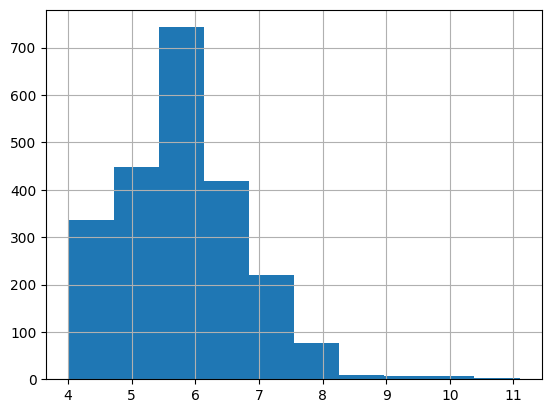

In [19]:
compound_info.activity.hist()

In [20]:
compound_info.activity.isna().value_counts()

False    2269
Name: activity, dtype: int64

In [21]:
def get_prefix(cid):
    return cid.split("-", 1)[0]

cid_prefix = [get_prefix(cid) for cid in compound_info.compound_id]
ftbl = Counter(cid_prefix)
print(ftbl)

Counter({'PostEra': 1313, 'GoStar': 803, 'Kitamura': 32, 'Kneller': 8, 'Gentile': 8, 'world_drugs': 5, 'enamine': 4, 'other': 4, 'emolecules': 4, 'CHEMBL566136': 1, 'CHEMBL4303376': 1, 'CHEMBL1374426': 1, 'CHEMBL188434': 1, 'CHEMBL505670': 1, 'CHEMBL1201236': 1, 'CHEMBL505308': 1, 'CHEMBL111654': 1, 'CHEMBL119171': 1, 'CHEMBL4303312': 1, 'CHEMBL9116': 1, 'CHEMBL929': 1, 'CHEMBL4303361': 1, 'CHEMBL1977761': 1, 'CHEMBL3545085': 1, 'CHEMBL477197': 1, 'CHEMBL8260': 1, 'CHEMBL1886408': 1, 'CHEMBL2368547': 1, 'CHEMBL1382627': 1, 'CHEMBL4303503': 1, 'CHEMBL164': 1, 'CHEMBL444186': 1, 'CHEMBL596674': 1, 'CHEMBL226652': 1, 'CHEMBL1201073': 1, 'CHEMBL128251': 1, 'CHEMBL1356238': 1, 'CHEMBL1271993': 1, 'CHEMBL52': 1, 'CHEMBL508112': 1, 'CHEMBL480': 1, 'CHEMBL508280': 1, 'CHEMBL297453': 1, 'CHEMBL178459': 1, 'CHEMBL1200930': 1, 'CHEMBL66953': 1, 'CHEMBL55400': 1, 'CHEMBL3392049': 1, 'CHEMBL388676': 1, 'CHEMBL271023': 1, 'CHEMBL1188627': 1, 'CHEMBL1380480': 1, 'CHEMBL1616': 1, 'chembl': 1, 'CHEMBL4

In [22]:
def remove_substring(cid, substrings_to_remove=["PostEra-", "GoStar-", "other-"]):
    for substring in substrings_to_remove:
        cid = cid.replace(substring, "")
    return cid

compound_ids_from_info = set([remove_substring(cid) for cid in compound_info.compound_id])
intersection_info = compound_ids.intersection(compound_ids_from_info)
len(intersection_info)

941

In [23]:
# compound_ids_from_info = set(compound_info.compound_id)
# intersection_info = compound_ids.intersection(compound_ids_from_info)
# len(intersection_info)

In [24]:
compound_info_2 = pd.read_csv(os.path.join(data_dir, "eval", "mpro_exp_data2.csv"))
compound_info_2

,Unnamed: 0,compound_id,rdkit_smiles,active,cluster
0,0,CHEMBL478284,CN(C)C(=O)C(=O)c1cn(C)c2cc(Cl)c(C(=O)N3CCC(Cc4...,0,1982
1,1,ZINC142824,CC(=O)Nc1ccccc1,0,1966
2,2,CHEMBL269644,CC(=O)Nc1ccccc1,0,1990
3,3,CHEMBL379761,CC(C)c1c(NC(=O)Nc2ccc(Cl)cc2)c(=O)n(-c2ccccc2)n1C,0,1924
4,4,ZINC14976923,CC(C)c1c(NC(=O)Nc2ccc(Cl)cc2)c(=O)n(-c2ccccc2)n1C,0,1989
...,...,...,...,...,...
2848,35,LON-WEI-b2874fec-26,CNCC1CCCN(C(=O)[C@@H](c2ccccc2)N2Cc3ccccc3C2=O)C1,1,1992
2849,36,LON-WEI-b2874fec-27,CN(C)C(=O)C(CNC(=O)[C@@H](c1ccccc1)N1Cc2ccccc2...,1,1968
2850,37,JOH-UNI-61f30276-2,O=c1[nH]c(Cc2cccc(C(F)(F)F)c2)nc2cnccc12,1,1900
2851,38,JOH-UNI-61f30276-3,O=c1[nH]c(Cc2cccc(S(F)(F)(F)(F)F)c2)nc2cnccc12,1,1943


In [25]:
compound_ids_from_info_2 = set(compound_info_2.compound_id)
intersection_info_2 = compound_ids.intersection(compound_ids_from_info_2)
len(intersection_info_2)

1497

In [26]:
compound_info_3 = pd.read_csv(os.path.join(data_dir, "postera_activity_data_10132021.csv"))
compound_info_3

,SMILES,CID,canonical_CID,r_inhibition_at_20_uM,r_inhibition_at_50_uM,r_avg_IC50,f_inhibition_at_20_uM,f_inhibition_at_50_uM,f_avg_IC50,f_avg_pIC50,relative_solubility_at_20_uM,relative_solubility_at_100_uM,trypsin_IC50,NMR_std_ratio,acrylamide,chloroacetamide,series,frag_id
0,COC(=O)CN(C)S(=O)(=O)N1Cc2ccc(Cl)cc2C(C(=O)Nc2...,MAT-POS-af1eef35-2,MAT-POS-af1eef35-2,NaN,NaN,NaN,NaN,NaN,0.064774,NaN,NaN,NaN,NaN,NaN,False,False,3-aminopyridine-like,NaN
1,N#CC1(CS(=O)(=O)N2Cc3ccc(Cl)cc3[C@H](C(=O)Nc3c...,MAT-POS-e194df51-1,MAT-POS-e194df51-1,NaN,NaN,NaN,NaN,NaN,0.036834,NaN,NaN,NaN,NaN,NaN,False,False,3-aminopyridine-like,NaN
2,N#CC1(CS(=O)(=O)N2Cc3ccc(Cl)cc3[C@@H](C(=O)Nc3...,MAT-POS-e194df51-2,MAT-POS-e194df51-2,NaN,NaN,NaN,NaN,NaN,4.112868,NaN,NaN,NaN,NaN,NaN,False,False,3-aminopyridine-like,NaN
3,O=C(Nc1cncc2cc(F)ccc12)[C@H]1CCS(=O)(=O)c2ccc(...,MAT-POS-86c60949-1,MAT-POS-86c60949-1,NaN,NaN,NaN,NaN,NaN,24.543083,NaN,NaN,NaN,NaN,NaN,False,False,3-aminopyridine-like,NaN
4,CC(C)(O)c1ccc2cncc(NC(=O)C3CCNc4ccc(Cl)cc43)c2c1,MAT-POS-86c60949-2,MAT-POS-86c60949-2,NaN,NaN,NaN,NaN,NaN,0.353118,NaN,NaN,NaN,NaN,NaN,False,False,3-aminopyridine-like,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1496,N#Cc1cc(Cl)cc(NC(=O)Nc2cccnc2)c1,WAR-XCH-eb7b662f-2,WAR-XCH-eb7b662f-2,NaN,NaN,NaN,NaN,NaN,99.010000,NaN,NaN,NaN,99.0,NaN,False,False,3-aminopyridine-like,NaN
1497,N#Cc1cccc(NC(=O)Nc2cncc(N)c2)c1,DAR-DIA-23aa0b97-8,DAR-DIA-23aa0b97-8,NaN,NaN,NaN,NaN,NaN,54.272964,NaN,NaN,NaN,99.0,NaN,False,False,3-aminopyridine-like,NaN
1498,N#Cc1cccc(NC(=O)Nc2c[nH]c3ncccc23)c1,DAR-DIA-23aa0b97-11,DAR-DIA-23aa0b97-11,NaN,NaN,NaN,NaN,NaN,63.554925,NaN,NaN,NaN,99.0,NaN,False,False,3-aminopyridine-like,NaN
1499,N#Cc1cccc(NC(=O)Cc2cncc3ccccc23)c1,DAR-DIA-23aa0b97-19,DAR-DIA-23aa0b97-19,NaN,NaN,14.641091,NaN,NaN,26.680129,NaN,NaN,NaN,NaN,NaN,False,False,3-aminopyridine-like,NaN


In [27]:
compound_ids_from_info_3 = set(compound_info_3.CID)
intersection_info_3 = compound_ids.intersection(compound_ids_from_info_3)
len(intersection_info_3)

1501

In [28]:
na_list = compound_info_3.f_avg_IC50.isna()
na_list
#  = split_info[split_info.cmpd_id.isin(compound_ids)]
compound_info_3[na_list]

,SMILES,CID,canonical_CID,r_inhibition_at_20_uM,r_inhibition_at_50_uM,r_avg_IC50,f_inhibition_at_20_uM,f_inhibition_at_50_uM,f_avg_IC50,f_avg_pIC50,relative_solubility_at_20_uM,relative_solubility_at_100_uM,trypsin_IC50,NMR_std_ratio,acrylamide,chloroacetamide,series,frag_id
432,O=C(C[C@@]1(C(=O)Nc2cncc3ccccc23)CCOc2ccc(Cl)c...,ALP-UNI-3496895b-8,ALP-UNI-3496895b-8,NaN,NaN,19.362400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,3-aminopyridine-like,NaN
554,O=C(C[C@@]1(C(=O)Nc2cncc3ccccc23)CCOc2ccc(Cl)c...,KAD-UNI-8a629cb0-21,KAD-UNI-8a629cb0-21,NaN,NaN,9.257844,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,NaN,NaN
702,O=C(Nc1cncc2cnccc12)[C@H]1CCOc2ccc(Cl)cc21,ALP-POS-ce760d3f-2,ALP-POS-ce760d3f-2,NaN,NaN,1.291063,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,3-aminopyridine-like,NaN
771,COc1cc(Cl)cc2c1OCC[C@@H]2C(=O)Nc1cncc2ccccc12,MAT-POS-43fe65f4-1,MAT-POS-43fe65f4-1,NaN,NaN,10.203822,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,3-aminopyridine-like,NaN
789,COc1ccc2c(N)nn(C(=O)C3CCOc4ccc(Cl)cc43)c2c1,ALP-POS-79636100-2,ALP-POS-79636100-2,NaN,NaN,62.090051,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1464,Cc1ccn2c(-c3ccc4[nH]ncc4c3)c(-c3ccc(F)cc3)nc2c1,ALV-UNI-7ff1a6f9-14,ALV-UNI-7ff1a6f9-14,NaN,NaN,99.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,NaN,NaN
1468,CC1C(O)CCCN1Cc1ccccc1,MAK-UNK-6435e6c2-9,MAK-UNK-6435e6c2-9,NaN,NaN,99.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,NaN,x0464
1477,O=C(CCl)N1CCN(Cc2cccc(Cl)c2)C[C@@H]1Cc1ccccc1,DAN-LON-a5fc619e-10,DAN-LON-a5fc619e-10,NaN,NaN,18.850715,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,True,piperazine-chloroacetamide,NaN
1484,CS(=O)(=O)N(CCc1ccccc1)CC1CCN(C(=O)CCl)CC1,DUN-NEW-f8ce3686-25,DUN-NEW-f8ce3686-25,NaN,NaN,99.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,True,NaN,NaN


In [29]:
compound_info_3.f_avg_pIC50.isna().value_counts()
# compound_info_3[na_list].r_avg_IC50.isna().value_counts()

True    1501
Name: f_avg_pIC50, dtype: int64

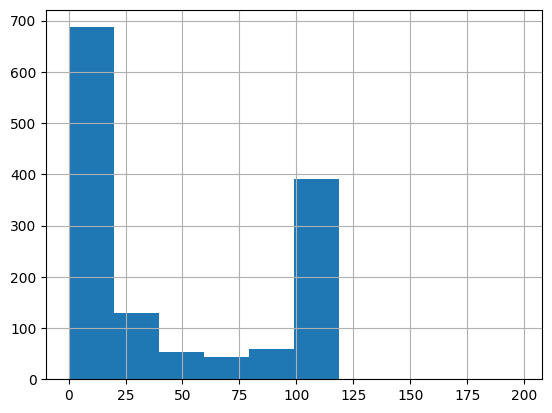

In [30]:
compound_info_3.f_avg_IC50.hist()
plt.show()

In [31]:
split_info = pd.read_csv(os.path.join(data_dir, "mpro_exp_data2_train_valid_test_ave_min_8aa6f8e2-4acc-461e-b8aa-9917eac1a337.csv"))
split_info

,cmpd_id,subset,fold
0,104679481,train,0
1,104680060,train,0
2,1161709,train,0
3,11748279,train,0
4,11798390,train,0
...,...,...,...
2191,ZINC591392,test,0
2192,ZINC68197423,test,0
2193,ZINC68267183,test,0
2194,ZINC72317473,test,0


In [32]:
split_info.subset.value_counts()

train    1955
test      128
valid     113
Name: subset, dtype: int64

In [33]:
compound_ids_from_split = set(split_info.cmpd_id)
intersection_split = compound_ids.intersection(compound_ids_from_split)
len(intersection_split)

1177

In [34]:
filtered_split_info = split_info[split_info.cmpd_id.isin(compound_ids)]
filtered_split_info.subset.value_counts()

train    1047
test       68
valid      62
Name: subset, dtype: int64

In [35]:
intersection_split_info = compound_ids_from_split.intersection(compound_ids_from_info)
len(intersection_split_info)

737

In [36]:
filtered_split_info_compound = split_info[split_info.cmpd_id.isin(compound_ids_from_info)]
filtered_split_info_compound.subset.value_counts()

train    679
test      33
valid     25
Name: subset, dtype: int64